# Testing the CT Current Sensor

In [2]:
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

## Simplify analysis with a function

In [38]:
# I'm defining an admittedly messy function to analyze the output from the 
# current sensor and create a nice plot with some useful metrics.

def analyze_sensor_data(data, sample_time, title=None):
    # Perform all kinds of caculations on the input data
    t = np.linspace(0, sample_time, len(data))
    high_ix = argrelextrema(data, np.greater, order=8)
    low_ix = argrelextrema(data, np.less, order=8)
    dt = sample_time / (len(data) * 1000)
    per = dt * np.concatenate([np.diff(high_ix), np.diff(low_ix)], axis=1).mean()
    freq = 1/per
    v_high = data[high_ix].mean()
    v_low = data[low_ix].mean()
    v_avg = (v_high + v_low) / 2
    v_rms = 0.3536 * (v_high - v_low)
    I = (100 / 333) * v_rms
    p = 120 * I

    # Create a plot and put lines on it
    fig = plt.figure(figsize=(7, 4))
    plt.plot(t, data, c='lightseagreen')       # The measured voltages
    plt.axhline(v_high, lw=1, c='k', ls='--')  # The average upper bound
    plt.axhline(v_low, lw=1, c='k', ls='--')   # The average lower bound
    plt.axhline(v_avg, lw=1, c='k', ls='--')   # Smack in the middle is the v_offset
    
    # Display useful metrics next to the plot
    plt.figtext(1, 0.75, fontdict={'size': 12}, s=f'Freq = {round(freq, 2)} Hz')
    plt.figtext(1, 0.68, fontdict={'size': 12}, s=f'v_high = {round(v_high, 2)} mV')
    plt.figtext(1, 0.61, fontdict={'size': 12}, s=f'v_low = {round(v_low, 2)} mV')
    plt.figtext(1, 0.54, fontdict={'size': 12}, s=f'offset = {round(v_avg, 2)} mV')
    plt.figtext(1, 0.47, fontdict={'size': 12}, s=f'v_pp = {round(v_high - v_low, 2)} mV')
    plt.figtext(1, 0.40, fontdict={'size': 12}, s=f'I = {round(I, 2)} A')
    plt.figtext(1, 0.33, fontdict={'size': 12}, s=f'P = {round(p, 2)} W')
    
    # Labels are good
    plt.xlabel('Elapsed Time (ms)')
    plt.ylabel('Voltage across CT (mv)')
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.show()

## Start testing

### Hot Water Kettle (Rated for 1500 W)

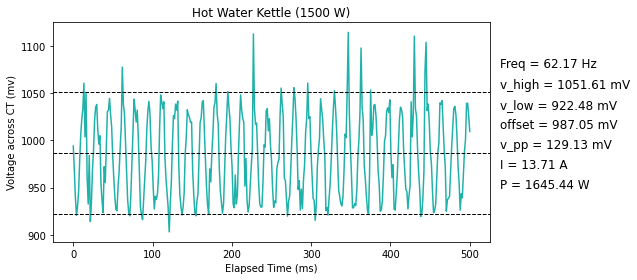

In [8]:
with open('./data/kettle-1500W.txt') as f:
    kettle_data = np.array([float(val) for val in f])
analyze_sensor_data(kettle_data, 500, title='Hot Water Kettle (1500 W)')

### Toaster (Rated for 900 W)

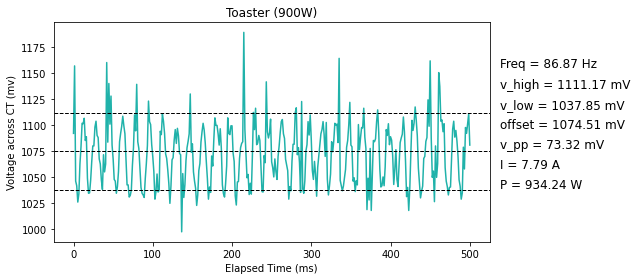

In [4]:
with open('./data/toaster-900W.txt') as f:
    toaster_data = np.array([float(val) for val in f])
analyze_sensor_data(toaster_data, 500, title='Toaster (900W)')

### Rice Cooker (Rated for 350 W)

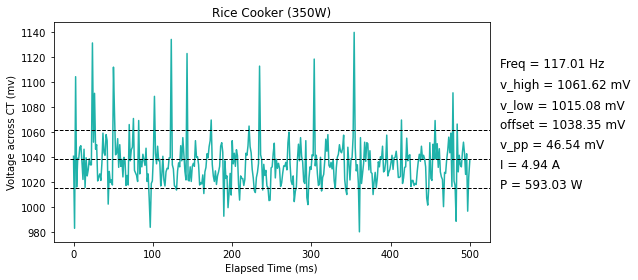

In [5]:
with open('./data/rice-cooker-350W.txt') as f:
    rice_cooker_data = np.array([float(val) for val in f])
analyze_sensor_data(rice_cooker_data, 500, title='Rice Cooker (350W)')

### Compact Fluorescent Light Bulb (Rated for 13 W)

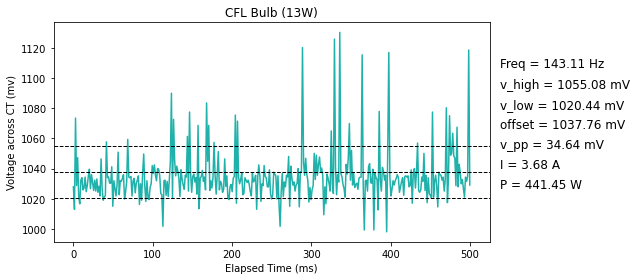

In [12]:
with open('./data/cfl-bulb-13W.txt') as f:
    cfl_bulb_data = np.array([float(val) for val in f])
analyze_sensor_data(cfl_bulb_data, 500, title='CFL Bulb (13W)')

471.004243281471

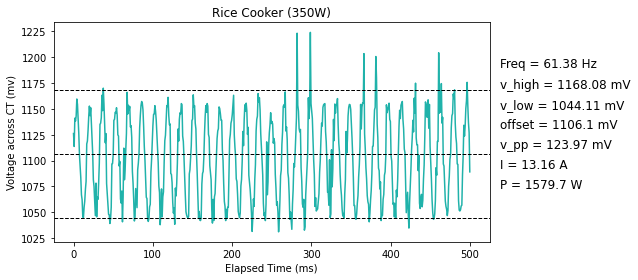

In [30]:
with open('./data/kettle_hifi.txt') as f:
    rice_cooker_data = np.array([float(val) for val in f])[:600]
analyze_sensor_data(rice_cooker_data, 500, title='Rice Cooker (350W)')

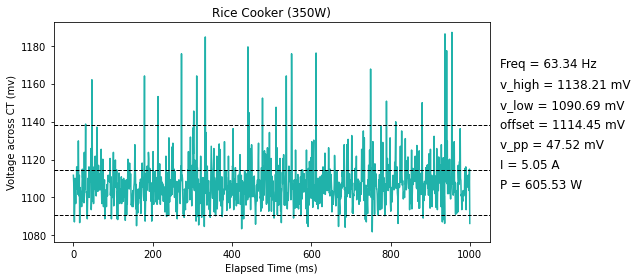

In [50]:
with open('./data/soldering-iron.txt') as f:
    rice_cooker_data = np.array([float(val) for val in f])
analyze_sensor_data(rice_cooker_data, 1000, title='Rice Cooker (350W)')

## Gates

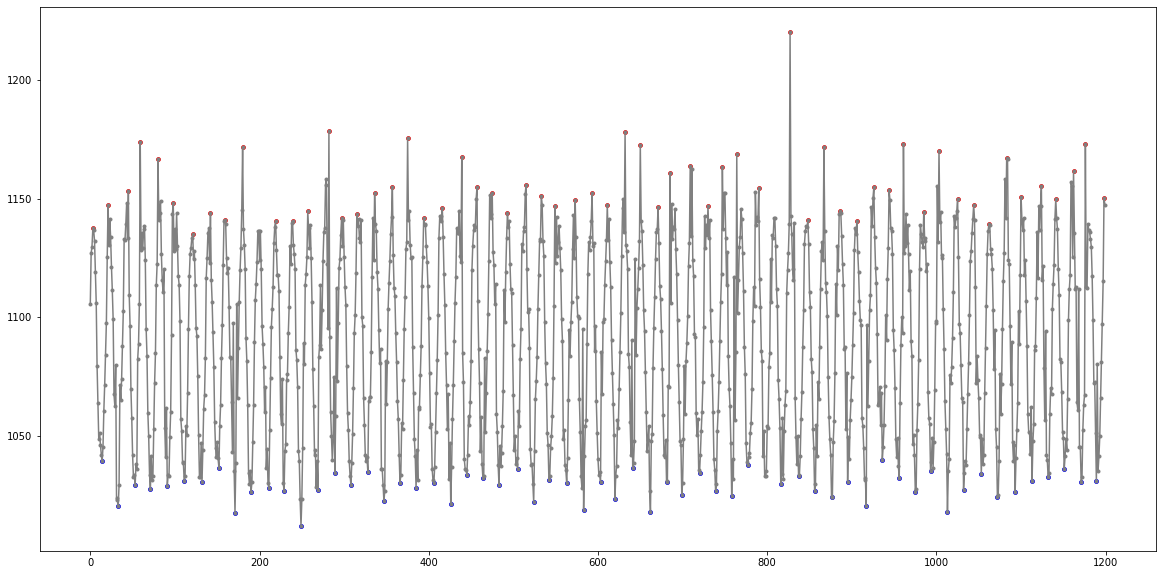

In [26]:
with open('./data/serial_data_20220127162230.txt') as f:
    data = np.array([float(val) for val in f])

maxima = argrelextrema(data, np.greater, order=6)
minima = argrelextrema(data, np.less, order=6)

plt.figure(figsize=(20, 10))
plt.plot(data, c='gray', marker='.')
plt.scatter(x=maxima, y=data[maxima], s=14, c='r')
plt.scatter(x=minima, y=data[minima], s=15, c='b');

In [11]:
373000/500

746.0

In [312]:
peaks = np.concatenate([data[minima][:5], data[maxima][:5]])
avg = peaks.mean()
diffs = np.abs(peaks - avg)
avg_diff = diffs.mean()


In [313]:
((data[maxima][5] - avg) - avg_diff) / avg_diff

-0.1759322737974863

In [314]:
(avg_diff * 1/(np.sqrt(2))) * 120 * 100/333

1680.740582163254

In [315]:
avg_diff

65.95969999999998

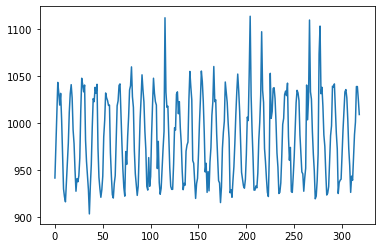

In [316]:
plt.plot(data[54:])

In [317]:
from collections import deque
from sklearn.metrics import mean_absolute_error
tol = 0.05
filtered_data = []
peaks = deque(np.concatenate([data[minima][:5], data[maxima][:5]]), maxlen=10)
for i, sample in enumerate(data[54:], 54):
    if sample == max(data[i-4:i+5]):
        peak_indicator = 1
    elif sample == min(data[i-4:i+5]):
        peak_indicator = -1
    else:
        peak_indicator = 0
        
    if peak_indicator:
        v_avg = np.mean(peaks)
        diffs = np.abs([peak - v_avg for peak in peaks])
        diff_avg = diffs.mean()
        sample_diff = np.abs(sample - v_avg)
        
        peaks.append(sample)
        
        if (sample_diff - diff_avg) / diff_avg > tol:
            sample = v_avg + peak_indicator * (1) * diff_avg
        
    filtered_data.append(sample)
        
        
        

        

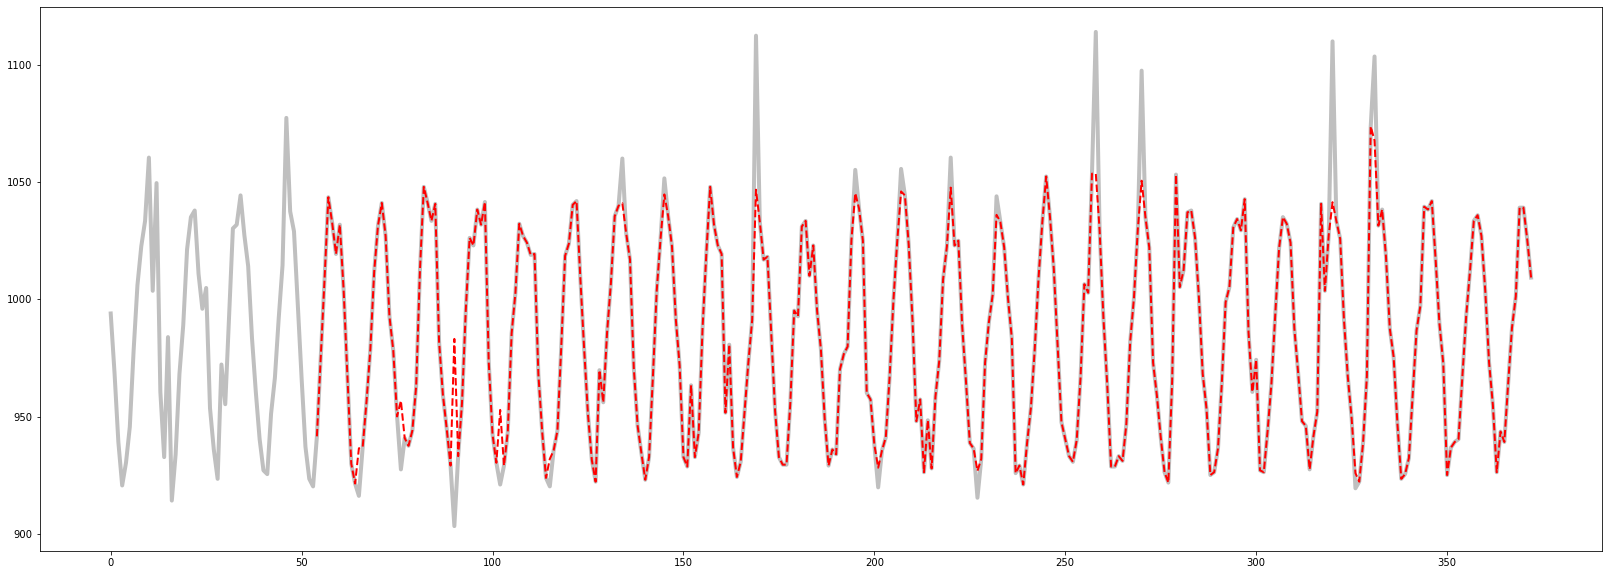

In [318]:
plt.figure(figsize=(28, 10))
plt.plot(data, lw=4, c='gray', alpha=0.5)
plt.plot(range(54, len(data)), filtered_data, lw=2, ls='--', c='r')

In [319]:
maxima = argrelextrema(np.array(filtered_data), np.greater, order=4)[0]
minima = argrelextrema(np.array(filtered_data), np.less, order=4)[0]

In [320]:
vm = np.concatenate([np.array(filtered_data)[maxima], np.array(filtered_data)[minima]]).mean()

In [321]:
np.abs(np.concatenate([np.array(filtered_data)[maxima], np.array(filtered_data)[minima]]) - vm).mean() * 1 / np.sqrt(2)

41.877872032731545

In [322]:
(41 / 333) * 100 * 120

1477.4774774774774

In [210]:
filtered_data[maxima]

TypeError: only integer scalar arrays can be converted to a scalar index

In [173]:
np.mean(peaks)

977.3673999999999

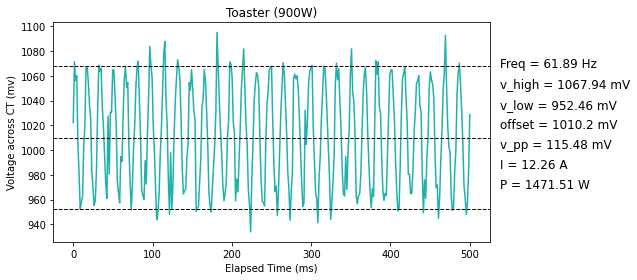

In [7]:
with open('./data/2021-01-26-TEST1.txt') as f:
    toaster_data = np.array([float(val) for val in f])
analyze_sensor_data(toaster_data, 500, title='Toaster (900W)')

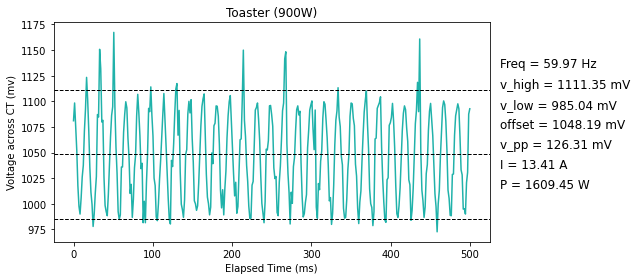

In [41]:
with open('./data/TEST123.txt') as f:
    toaster_data = np.array([float(val) for val in f])
analyze_sensor_data(toaster_data, 500, title='Toaster (900W)')

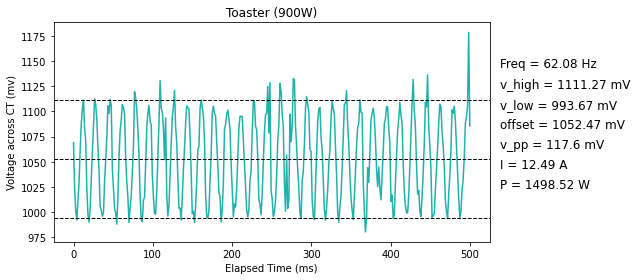

In [42]:
with open('./data/TEST456.txt') as f:
    toaster_data = np.array([float(val) for val in f])
analyze_sensor_data(toaster_data, 500, title='Toaster (900W)')

In [15]:
toaster_data.min()

863.4799